# 03 - Zeisel NIMFA

In [26]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from copy import deepcopy
from numpy import ma
from sklearn.decomposition import NMF, PCA
from sklearn.manifold import TSNE
from umap import UMAP

from sklearn.preprocessing import StandardScaler

import nimfa as ni
import scipy as sp

In [29]:
sp.__version__, np.__version__, pd.__version__

('1.1.0', '1.11.3', '0.23.1')

In [30]:
zeisel_path = '/media/tmo/data/work/datasets/zeisel/expression_sara_filtered.txt'
zeisel_meta_path = '/media/tmo/data/work/datasets/zeisel/expression_mRNA_17-Aug-2014.txt'

In [31]:
%%time
zeisel_df = pd.read_csv(zeisel_path, sep='\t', skiprows=1, header=None, index_col=0)
zeisel_df.index.name = 'gene'

CPU times: user 4.96 s, sys: 360 ms, total: 5.32 s
Wall time: 5.32 s


In [32]:
zeisel_meta_df = pd.read_table(zeisel_meta_path, nrows=12, index_col=1, header=None)
zeisel_meta_df.drop(zeisel_meta_df.columns[0], axis=1, inplace=True)
zeisel_meta_df = zeisel_meta_df.T.reset_index()[['tissue', 'level1class', 'level2class']]
zeisel_meta_df.index.name = 'cell'

In [33]:
for meta_col in zeisel_meta_df.columns:
    zeisel_meta_df[meta_col] = zeisel_meta_df[meta_col].astype('category')

In [34]:
zeisel_meta_df.head()

1,tissue,level1class,level2class
cell,,,
0,sscortex,interneurons,Int10
1,sscortex,interneurons,Int10
2,sscortex,interneurons,Int6
3,sscortex,interneurons,Int10
4,sscortex,interneurons,Int9


In [136]:
level1_counts = zeisel_meta_df['level1class'].value_counts()

In [137]:
level1_counts

pyramidal CA1           939
oligodendrocytes        820
pyramidal SS            399
interneurons            290
endothelial-mural       235
astrocytes_ependymal    224
microglia                98
Name: level1class, dtype: int64

In [150]:
level2_counts = zeisel_meta_df['level2class'].value_counts()

In [36]:
c = pd.concat([zeisel_meta_df[['level1class']], pd.DataFrame(zeisel_meta_df['level1class'].cat.codes.T, columns=['code'])], axis=1)

In [37]:
level1_map = dict(c.drop_duplicates()[['code', 'level1class']].values)
level1_map

{0: 'astrocytes_ependymal',
 1: 'endothelial-mural',
 2: 'interneurons',
 3: 'microglia',
 4: 'oligodendrocytes',
 5: 'pyramidal CA1',
 6: 'pyramidal SS'}

In [121]:
colors7 = list(plt.cm.get_cmap('tab10', 7).colors)

In [122]:
colors7

[array([ 0.12156863,  0.46666667,  0.70588235,  1.        ]),
 array([ 1.        ,  0.49803922,  0.05490196,  1.        ]),
 array([ 0.83921569,  0.15294118,  0.15686275,  1.        ]),
 array([ 0.54901961,  0.3372549 ,  0.29411765,  1.        ]),
 array([ 0.89019608,  0.46666667,  0.76078431,  1.        ]),
 array([ 0.7372549 ,  0.74117647,  0.13333333,  1.        ]),
 array([ 0.09019608,  0.74509804,  0.81176471,  1.        ])]

In [123]:
colors_by_level1code = dict(zip(level1_map.keys(), colors7))
colors_by_level1class = dict(zip(level1_map.values(), colors7))

In [124]:
colors_by_level1class

{'astrocytes_ependymal': array([ 0.12156863,  0.46666667,  0.70588235,  1.        ]),
 'endothelial-mural': array([ 1.        ,  0.49803922,  0.05490196,  1.        ]),
 'interneurons': array([ 0.83921569,  0.15294118,  0.15686275,  1.        ]),
 'microglia': array([ 0.54901961,  0.3372549 ,  0.29411765,  1.        ]),
 'oligodendrocytes': array([ 0.89019608,  0.46666667,  0.76078431,  1.        ]),
 'pyramidal CA1': array([ 0.7372549 ,  0.74117647,  0.13333333,  1.        ]),
 'pyramidal SS': array([ 0.09019608,  0.74509804,  0.81176471,  1.        ])}

In [125]:
genes = zeisel_df.index

In [126]:
zeisel_m = zeisel_df.values

In [127]:
zeisel_m.shape

(13063, 3005)

In [42]:
zeisel_m

array([[0, 0, 0, ..., 0, 0, 1],
       [3, 1, 0, ..., 0, 0, 1],
       [3, 1, 6, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 7, ..., 0, 0, 0]])

In [43]:
zeisel_binary_m = np.where(zeisel_m > 0, 1, 0)
zeisel_binary_m.shape

(13063, 3005)

In [44]:
scaler = StandardScaler(with_mean=False, with_std=True)

In [45]:
zeisel_m = scaler.fit_transform(zeisel_df.T.reset_index(drop=True)).T

In [46]:
zeisel_m.shape

(13063, 3005)

---

# Plotting

In [133]:
def plot_embedding(embedding_df): 
    enhanced = pd.concat([embedding_df, zeisel_meta_df['level1class']], axis=1)
    
    _, ax = plt.subplots()
    for key, group in enhanced.groupby('level1class'):    
        group.plot.scatter(ax=ax, x=0, y=1, label=key, color = colors_by_level1class[key], figsize=(16,12), s=20);
    
    plt.legend(markerscale=3, fontsize='large')
    plt.show()

In [97]:
def plot_embedding_sns(embedding_df):
    enhanced = pd.concat([embedding_df, zeisel_meta_df['level1class']], axis=1)
    
    sns.pairplot(x_vars=[0], y_vars=[1], data=enhanced, hue='level1class', size=12)
    
    plt.show()

In [98]:
def plot_coef(nmf_fit):
    color_list = list(map(lambda x: colors_by_level1code[x], zeisel_meta_df['level1class'].cat.codes))
    
    sns.clustermap(nmf_fit.coef(),
                   cmap='inferno',
                   metric='correlation',
                   col_colors=color_list,
                   robust=True,
                   figsize=(48, 16))
    plt.show()

---

# Classic NMF

In [162]:
%%time
classic_nmf_fit = ni.Nmf(zeisel_m, seed='nndsvd', objective='div', update='divergence')()

CPU times: user 11min 8s, sys: 13min 27s, total: 24min 36s
Wall time: 5min 20s


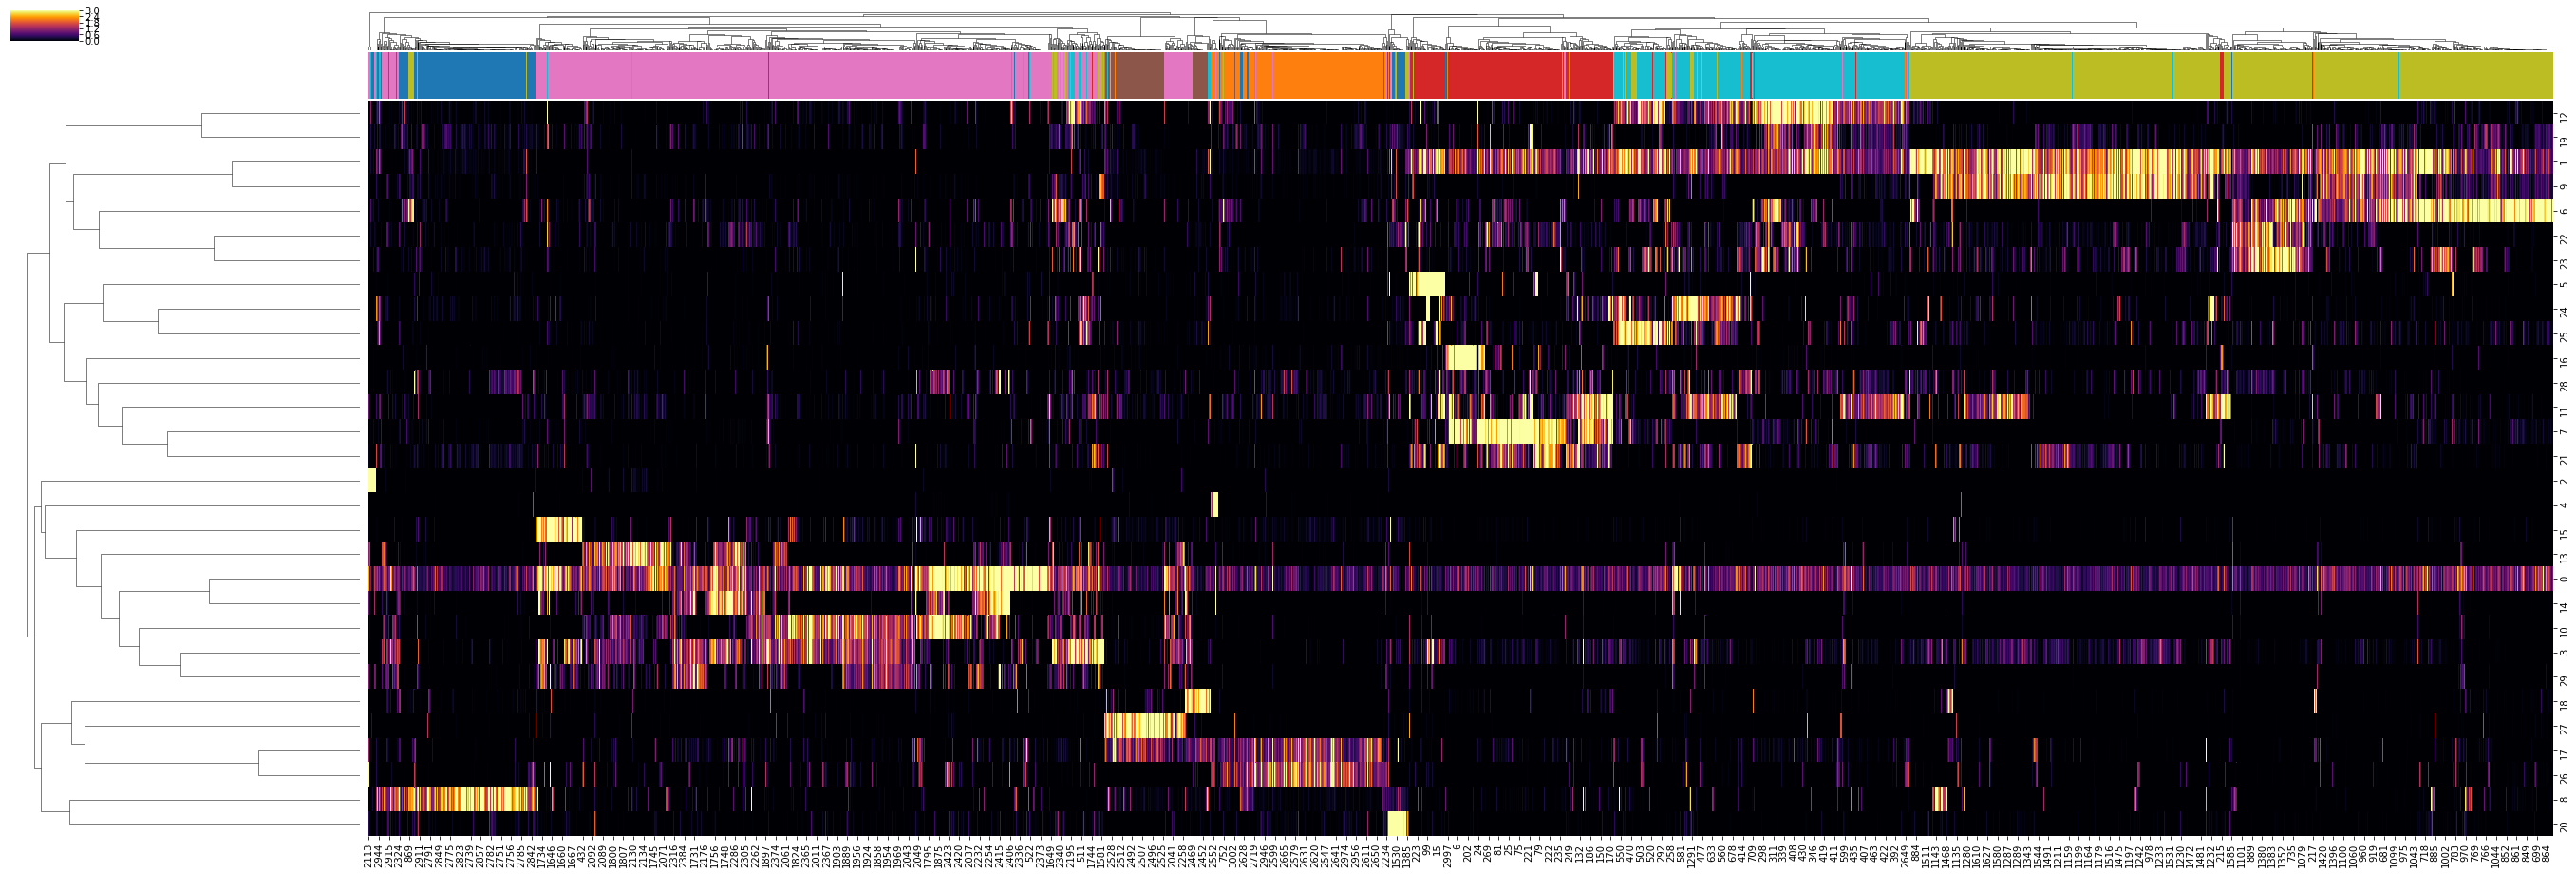

In [163]:
plot_coef(classic_nmf_fit)

In [257]:
def top_basis_genes(nmf_fit, idx, threshold=0.5):
    basis_i = np.ravel(nmf_fit.basis().T[idx])
    basis_i_df = pd.DataFrame({'weight': basis_i, 'gene': genes}).sort_values(by='weight', ascending=False)
    basis_i_top_df = basis_i_df[basis_i_df.weight > threshold]
    
    return basis_i_top_df

    #basis_i_top_df.plot(use_index=False)
    #plt.show()

In [276]:
topic_sizes = {i: len(top_basis_genes(classic_nmf_fit, i)) for i in range(0, 30)}

In [277]:
topic_sizes

{0: 422,
 1: 2010,
 2: 89,
 3: 727,
 4: 11,
 5: 47,
 6: 957,
 7: 590,
 8: 270,
 9: 368,
 10: 282,
 11: 514,
 12: 478,
 13: 144,
 14: 224,
 15: 358,
 16: 113,
 17: 303,
 18: 68,
 19: 329,
 20: 121,
 21: 446,
 22: 267,
 23: 351,
 24: 324,
 25: 329,
 26: 327,
 27: 191,
 28: 338,
 29: 170}

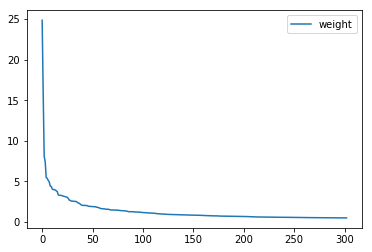

In [266]:
top_basis_genes(classic_nmf_fit, 17).plot(use_index=False)
plt.show()

In [285]:
for i in range(0, 30):
    top = top_basis_genes(classic_nmf_fit, i)[['gene']]
    size = len(top)
    top.to_csv('classic_nmf_basis_{0}_{1}'.format(i, size), header=None, index=None)

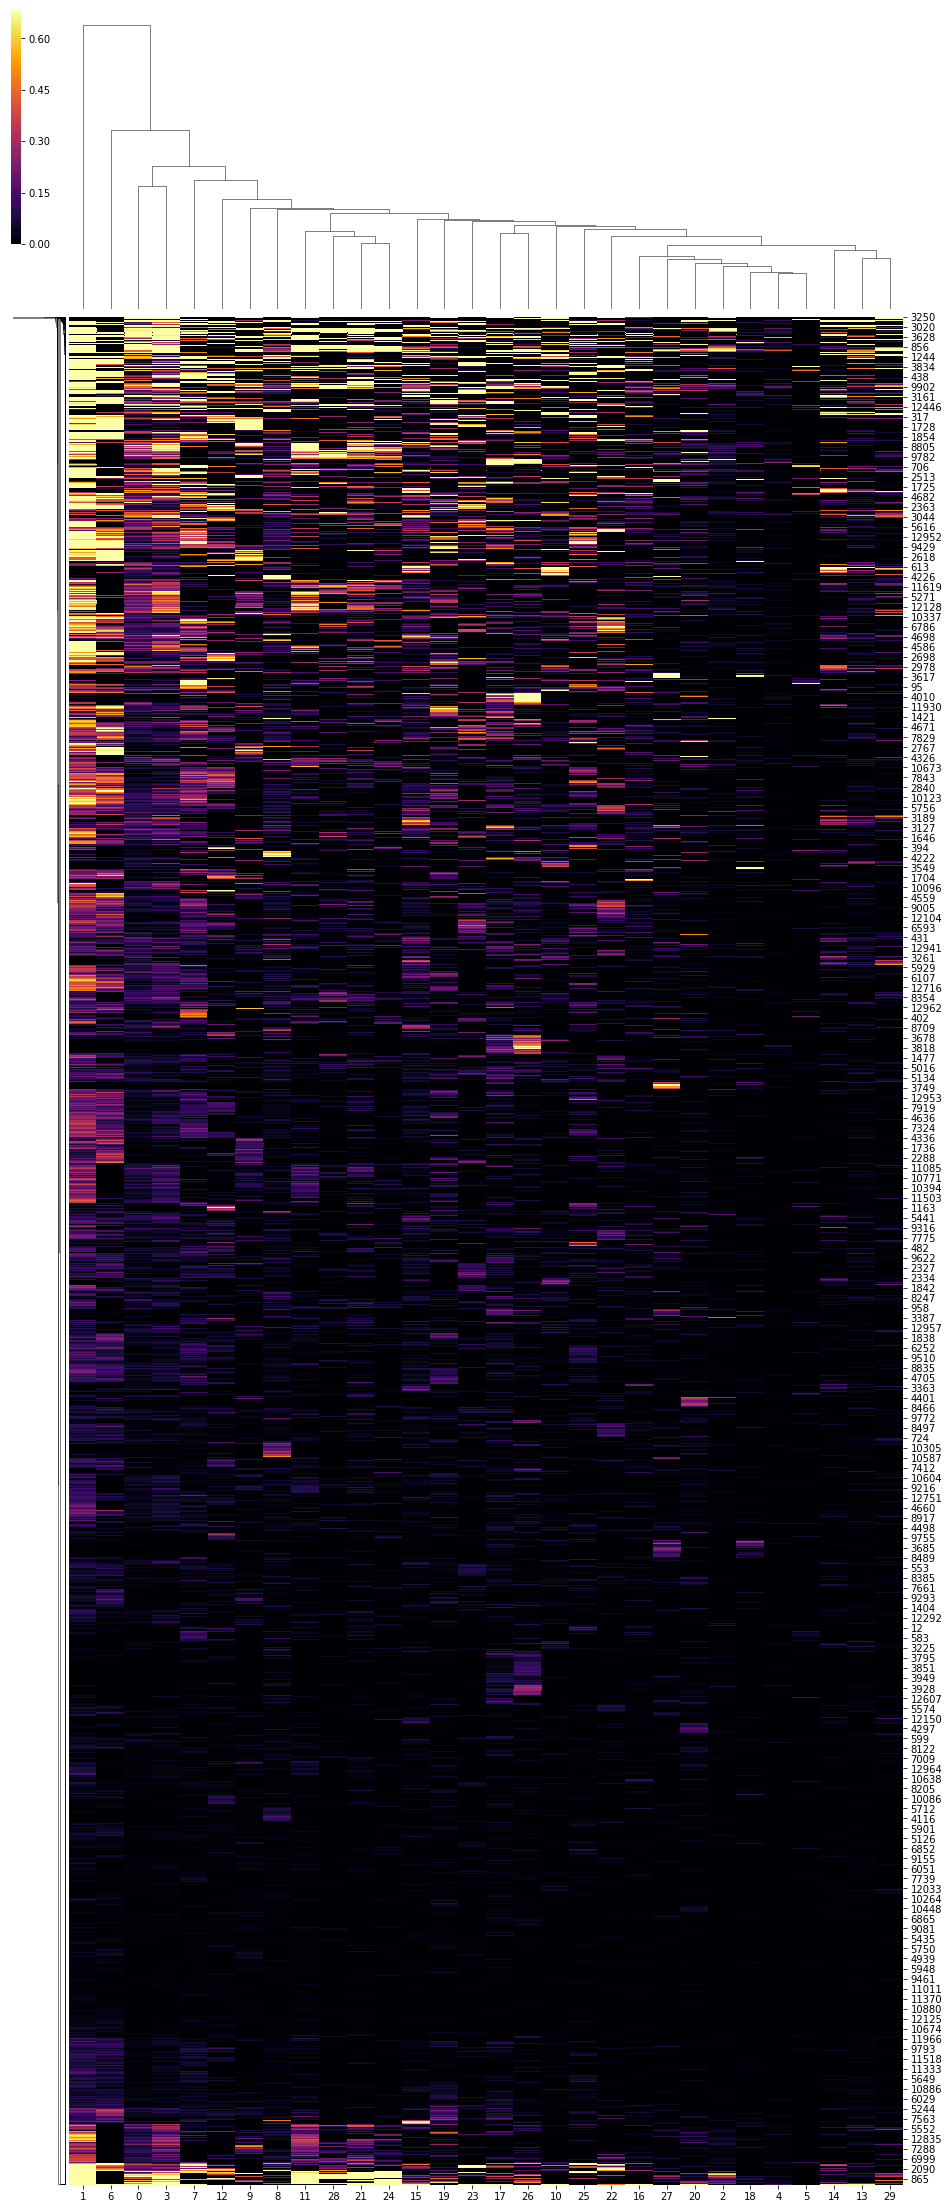

In [176]:
sns.clustermap(classic_nmf_fit.basis(),
               cmap='inferno',
               col_cluster=True,
               metric='cityblock',
               robust=True, 
               figsize=(16, 40))
plt.show()

In [164]:
%%time
classic_umap_df = pd.DataFrame(UMAP(random_state=666, metric='euclidean').fit_transform(classic_nmf_fit.coef().T))

CPU times: user 14.3 s, sys: 11.1 s, total: 25.4 s
Wall time: 12.4 s


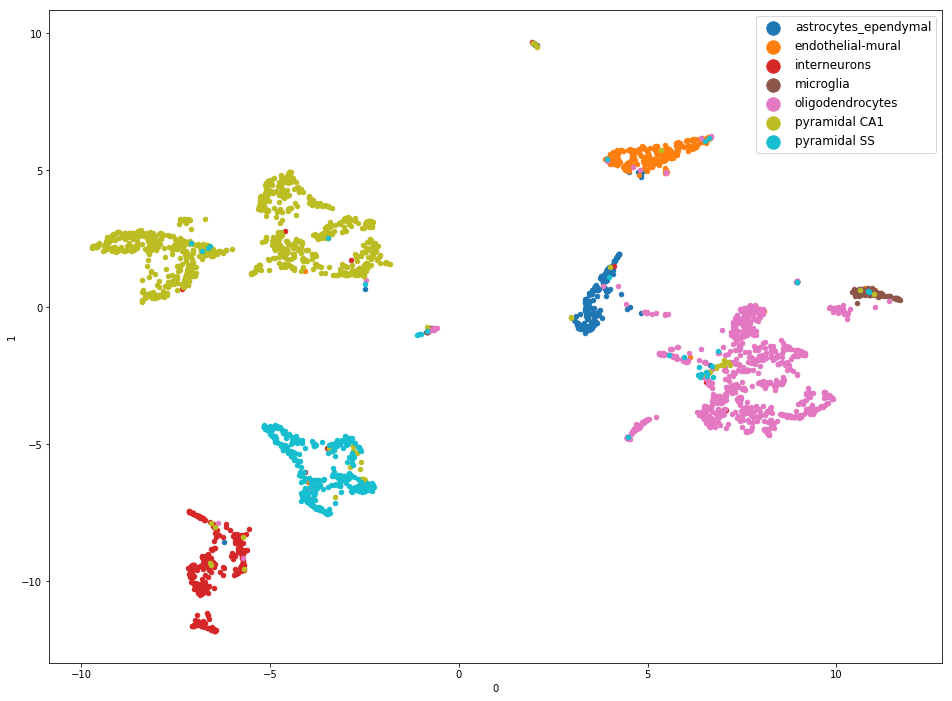

In [165]:
plot_embedding(classic_umap_df)

---

# Classic NMF - binary matrix

In [152]:
%%time
classic_nmf_bin_fit = ni.Nmf(zeisel_binary_m, seed='nndsvd', rank=40)()

CPU times: user 7min 23s, sys: 11min 44s, total: 19min 8s
Wall time: 1min 48s


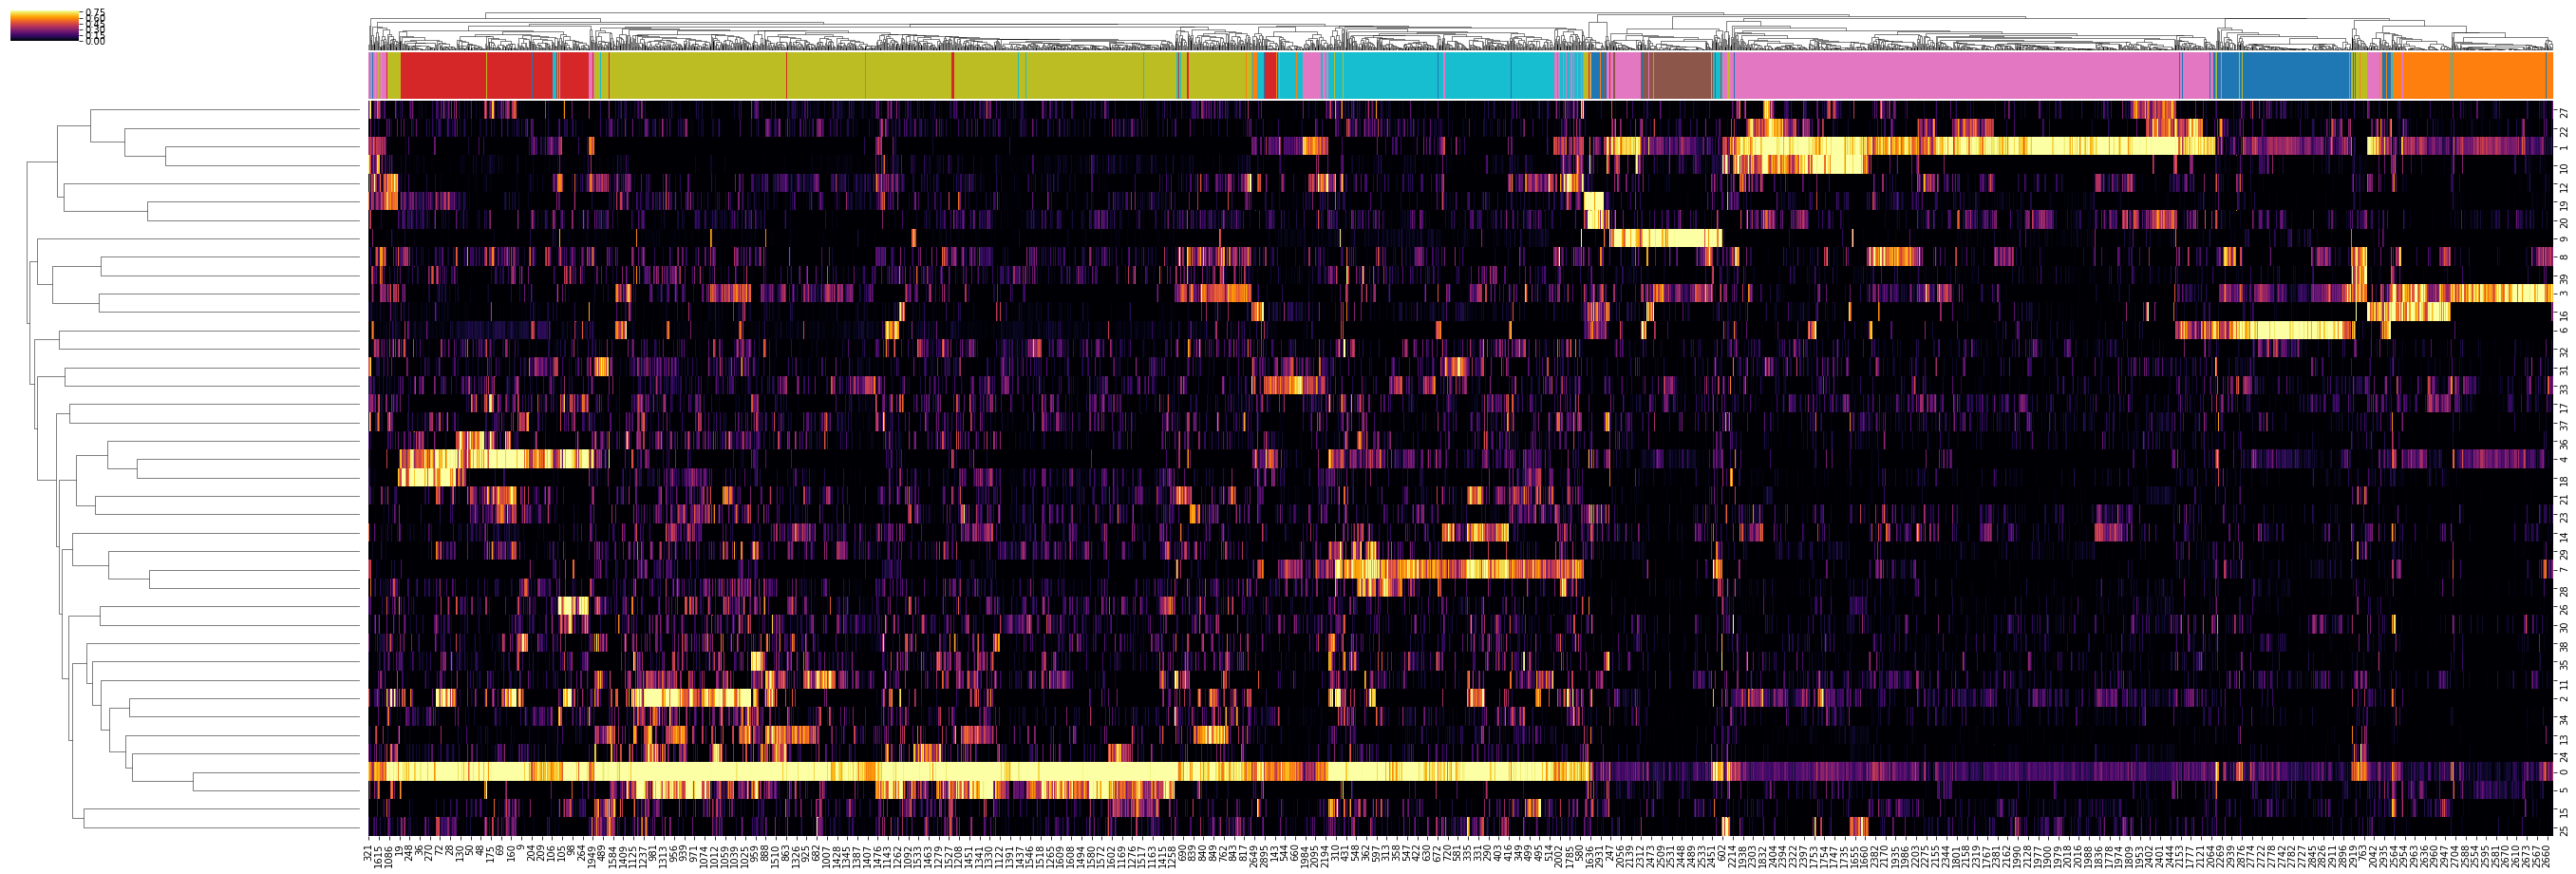

In [153]:
plot_coef(classic_nmf_bin_fit)

In [154]:
%%time
classic_umap_bin_df = pd.DataFrame(UMAP(random_state=666, metric='euclidean').fit_transform(classic_nmf_bin_fit.coef().T))

CPU times: user 14.6 s, sys: 11 s, total: 25.5 s
Wall time: 12.5 s


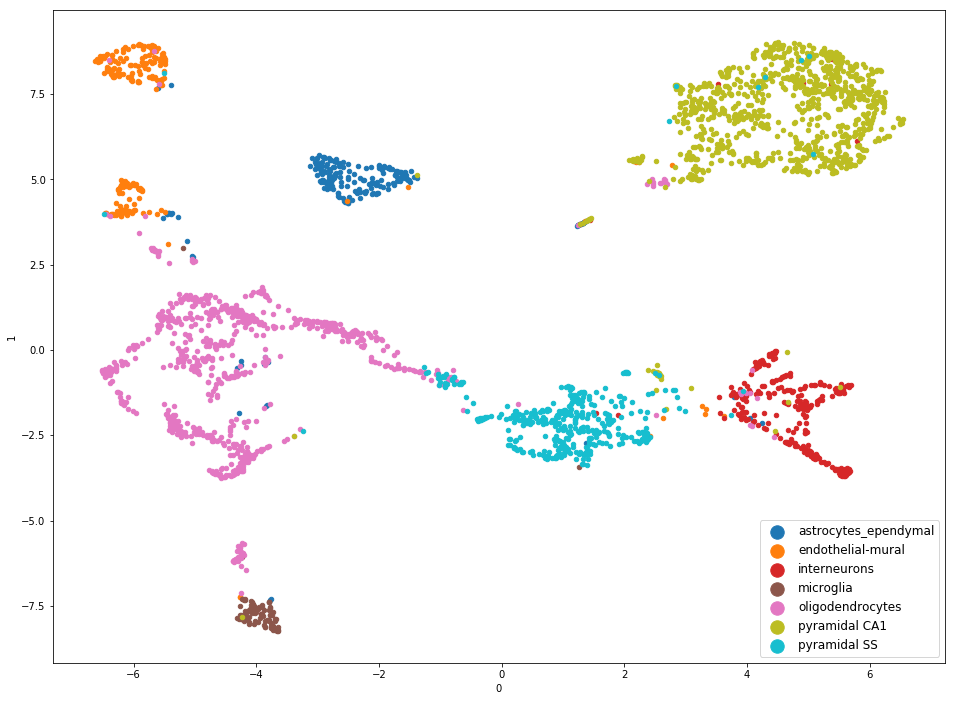

In [155]:
plot_embedding(classic_umap_bin_df)

---

# Alternating Least Squares Lsnmf

* seeds: `["random", "fixed", "nndsvd", "random_c", "random_vcol"]`

In [86]:
%%time
als_nmf_fit = ni.Lsnmf(zeisel_m, seed='nndsvd')()

CPU times: user 6min 34s, sys: 12min 36s, total: 19min 11s
Wall time: 53.1 s


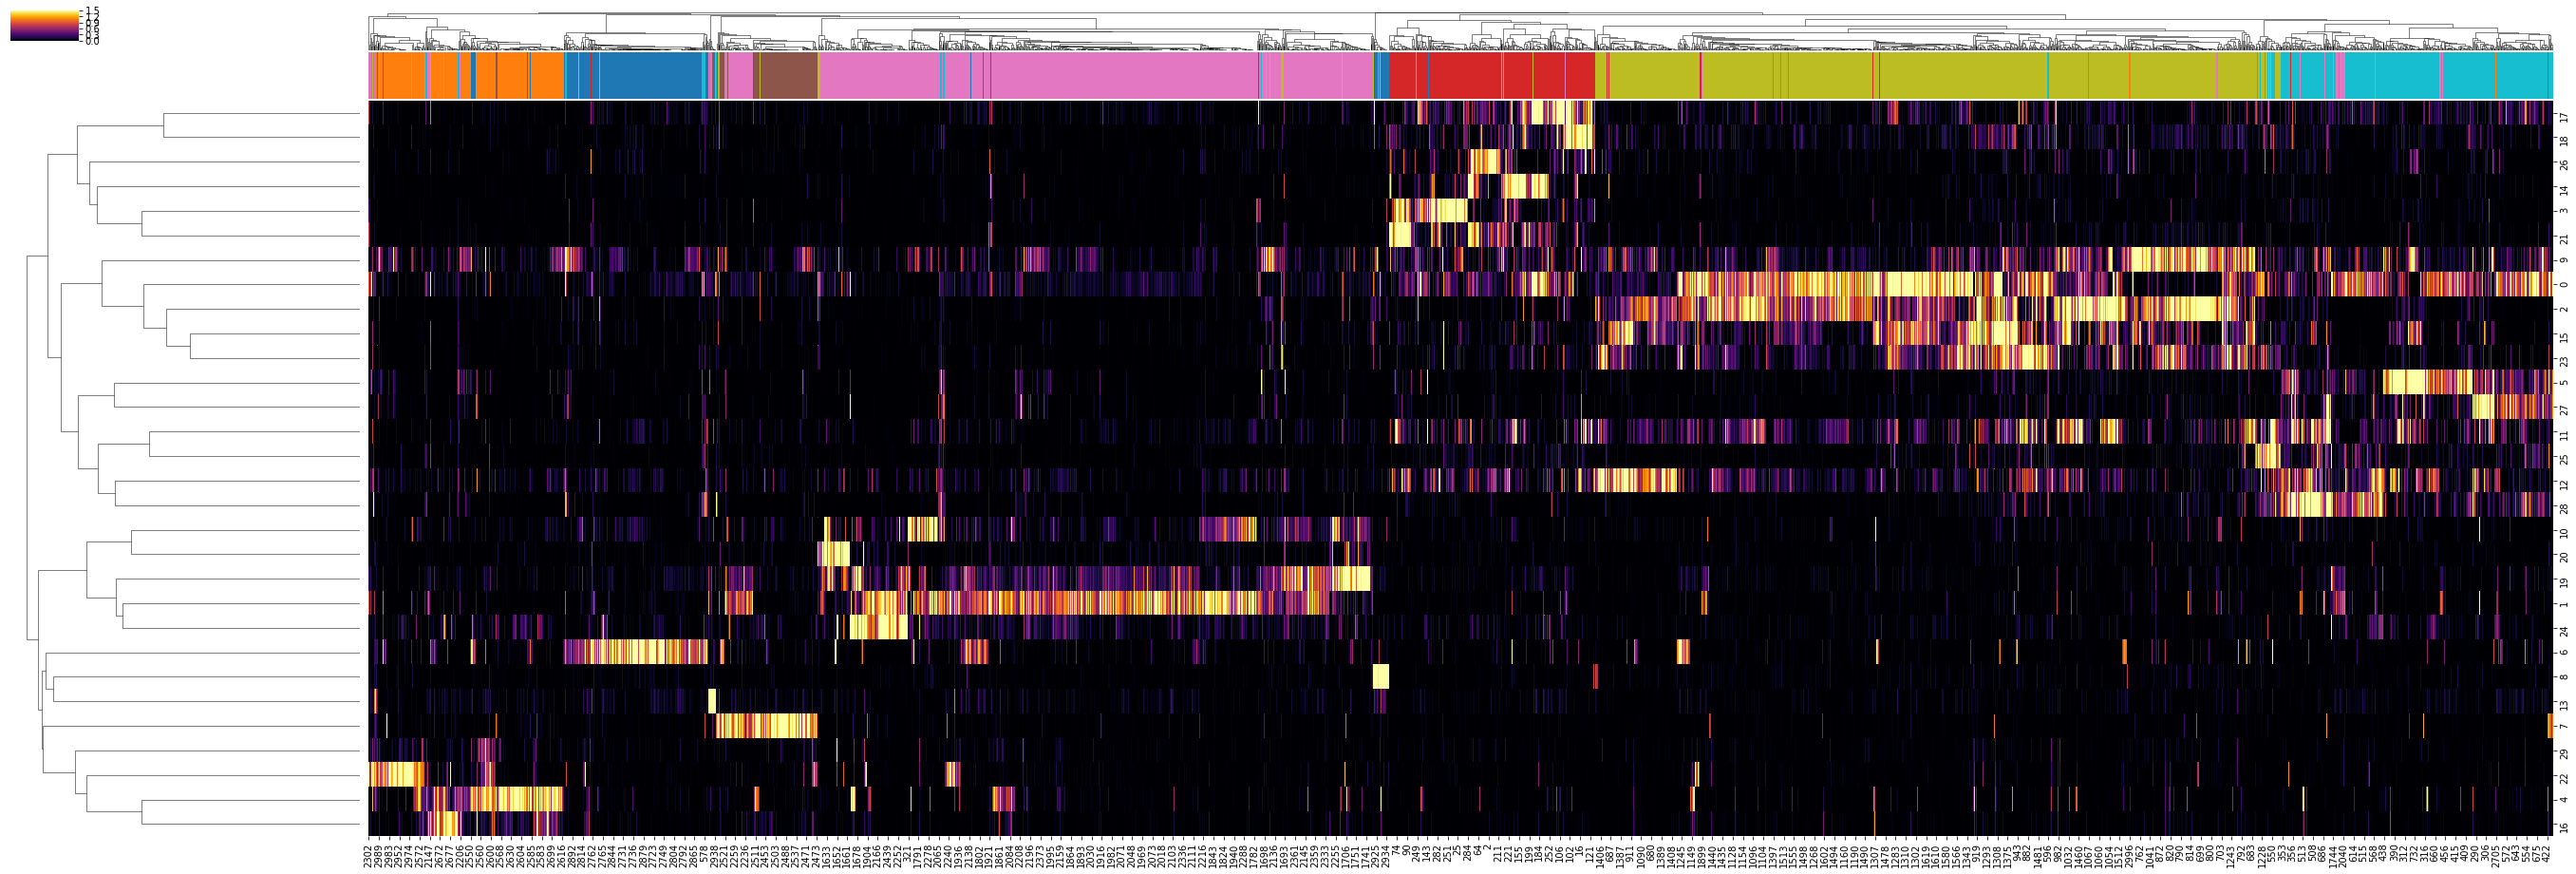

In [87]:
plot_coef(als_nmf_fit)

In [88]:
%%time
als_umap_df = pd.DataFrame(UMAP(random_state=666, metric='euclidean').fit_transform(als_nmf_fit.coef().T))

CPU times: user 14.4 s, sys: 11.7 s, total: 26.1 s
Wall time: 12.5 s


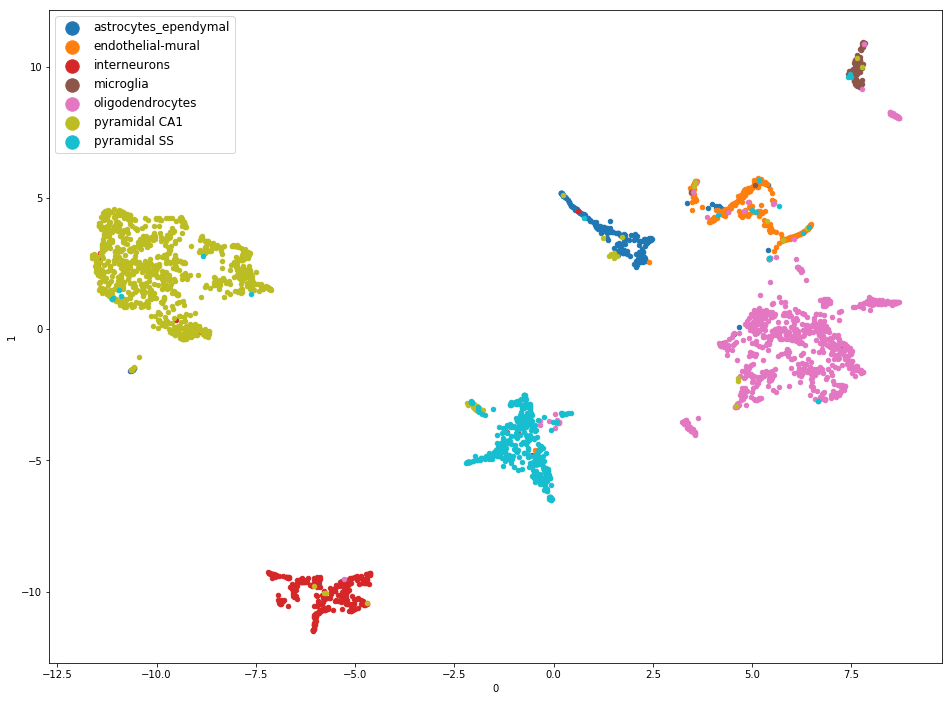

In [156]:
plot_embedding(als_umap_df)

---

# Probabilistic NMF

In [32]:
%%time
proba_nmf_fit = ni.Pmf(zeisel_m, rank=10, seed='nndsvd')()

KeyboardInterrupt: 

In [33]:
colors_by_level1class = list(map(lambda x: tab10_dict[x], zeisel_meta_df['level1class'].cat.codes))

sns.clustermap(proba_nmf_fit.coef(),
               cmap='inferno',
               metric='correlation',
               col_colors=colors_by_level1class,
               robust=True,
               figsize=(48, 16))
plt.show()

NameError: name 'proba_nmf_fit' is not defined

In [ ]:
%%time
proba_umap_df = pd.DataFrame(UMAP(random_state=666, metric='euclidean').fit_transform(proba_nmf_fit.coef().T))

In [ ]:
proba_umap_df.plot.scatter(x=0, y=1, c=zeisel_meta_df['level1class'].cat.codes, cmap=plt.cm.get_cmap('tab10', 7), figsize=(16,12))
plt.show()

---

# SPA selection - structured compression

* very fast
* requires standardization of expression levels

In [157]:
%%time
sep_spa_struct_fit = ni.SepNmf(zeisel_m, compression='structured', selection='spa')()

CPU times: user 1.41 s, sys: 1.11 s, total: 2.52 s
Wall time: 1.34 s


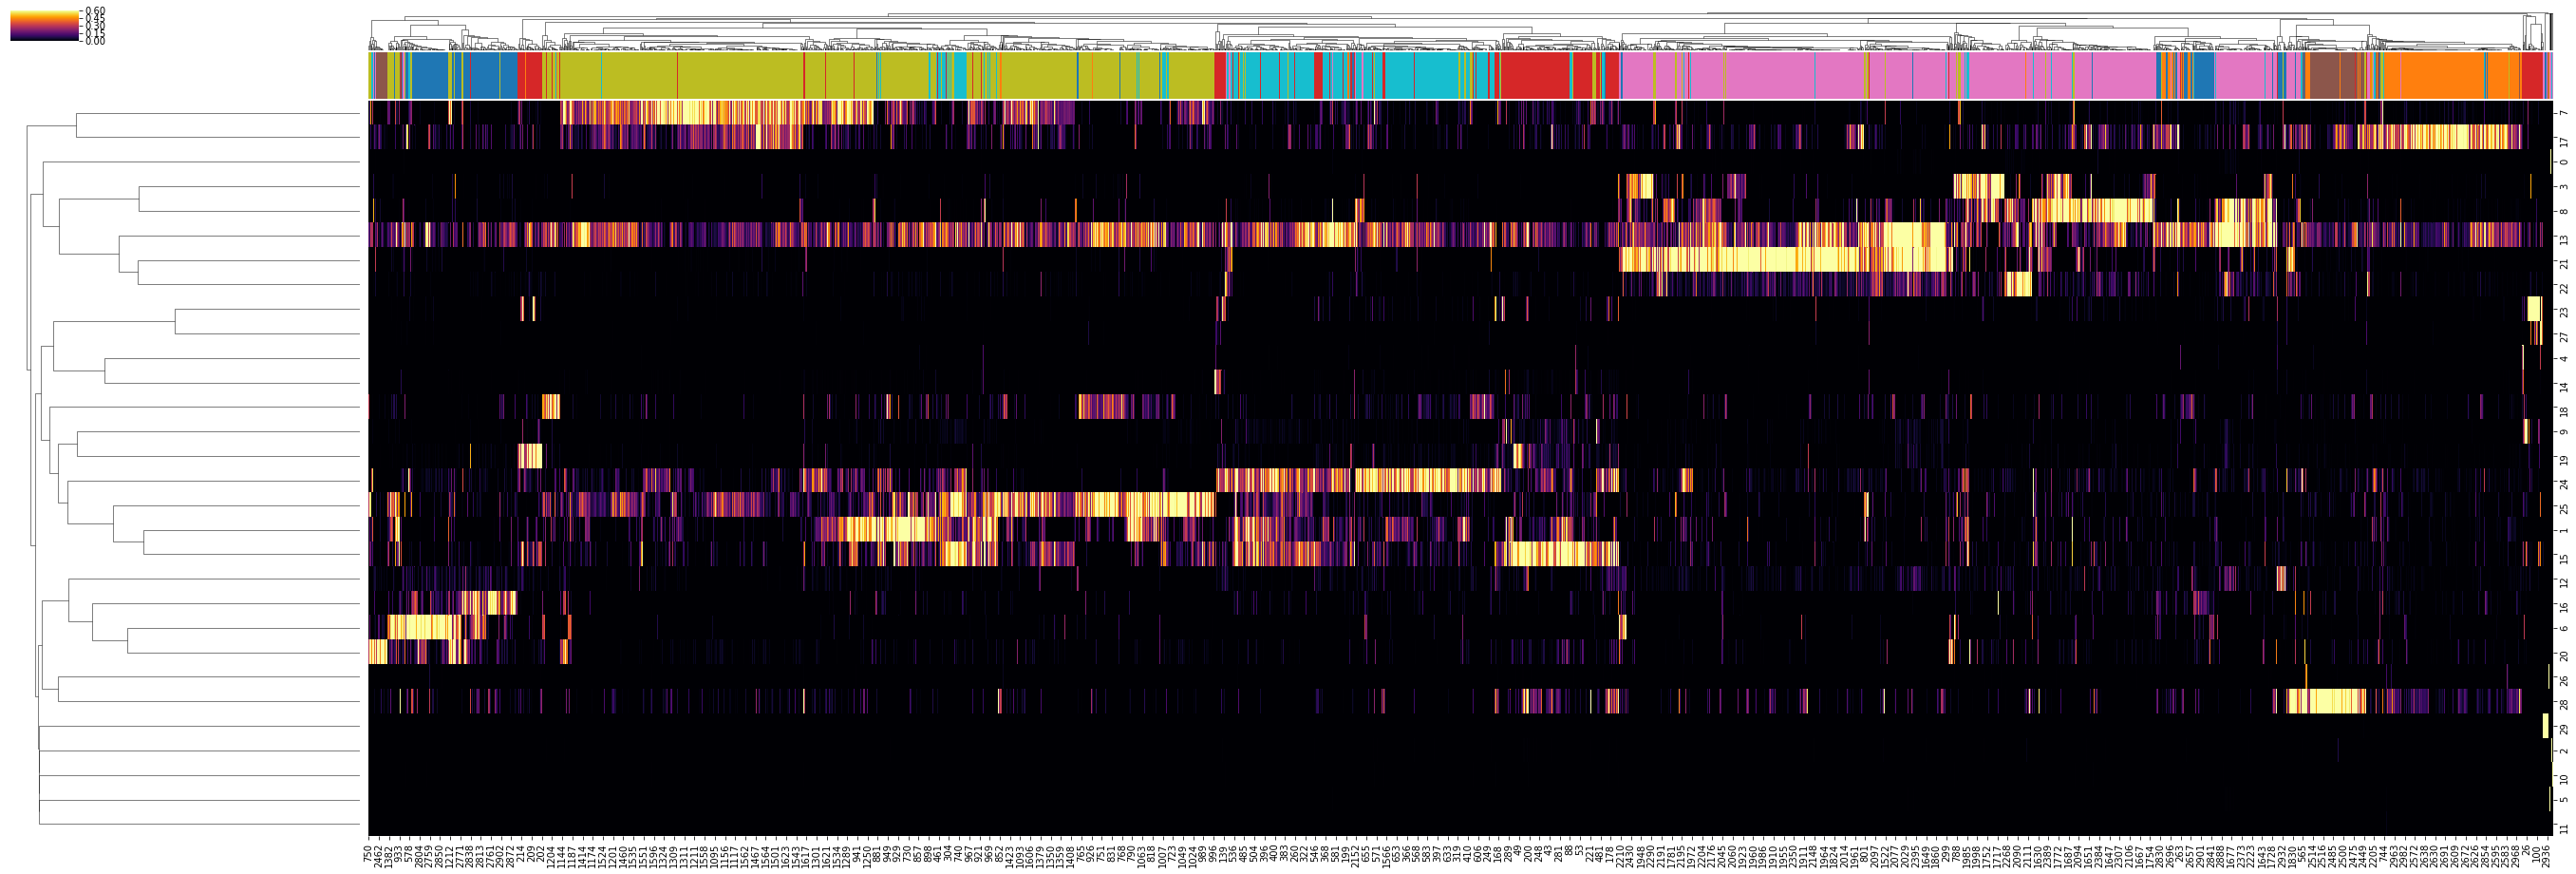

In [158]:
plot_coef(sep_spa_struct_fit)

In [ ]:
W = np.asarray(sep_spa_struct_fit.basis().T)

In [ ]:
def calculate_meta_genes(W, genes, threshold=.01):
    n_meta_genes = W.shape[0]
    
    meta_genes = []
    for i in range(n_meta_genes):
        w = pd.DataFrame(list(zip(list(W[i]), genes)), columns=['weight', 'gene'])
        w = w[w.weight > threshold].sort_values(by='weight', ascending=False)
        meta_genes.append(w)
    
    return meta_genes

In [ ]:
meta_genes = calculate_meta_genes(W, genes)

In [ ]:
sns.clustermap(sep_spa_struct_fit.basis().T,               
               cmap='inferno',
               col_cluster=False,
               metric='correlation',
               robust=True, 
               figsize=(40, 8))
plt.show()

In [159]:
%%time
sep_spa_struct_umap_df = pd.DataFrame(UMAP(random_state=666).fit_transform(sep_spa_struct_fit.coef().T))

CPU times: user 14.5 s, sys: 11.4 s, total: 25.9 s
Wall time: 12.3 s


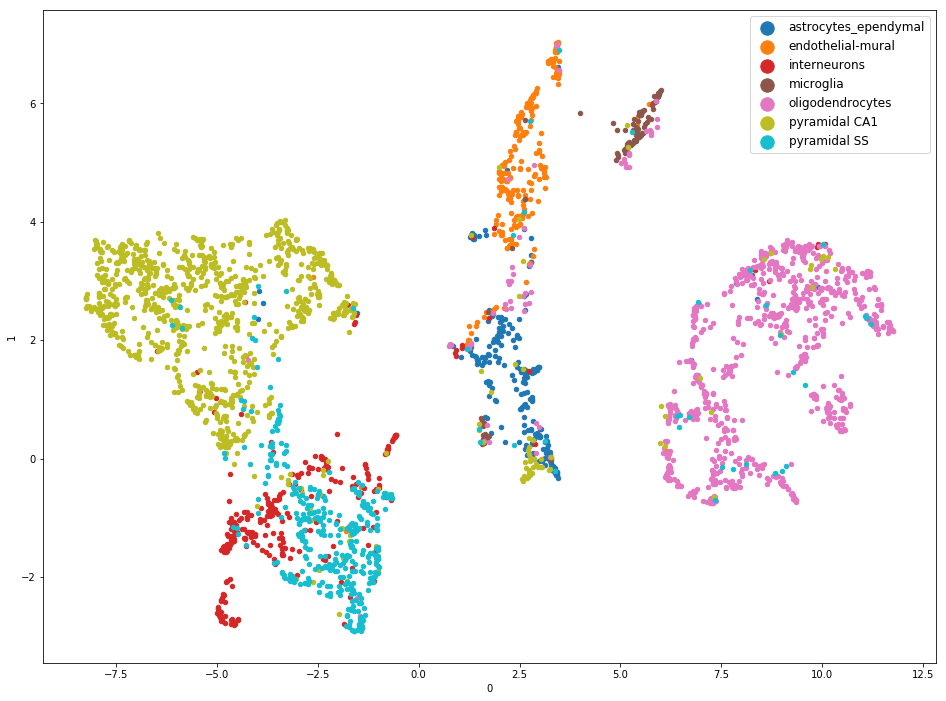

In [160]:
plot_embedding(sep_spa_struct_umap_df)

In [ ]:
%%time
sep_spa_struct_tsne_df = pd.DataFrame(TSNE(random_state=666).fit_transform(sep_spa_struct_fit.coef().T))

In [ ]:
sep_spa_struct_tsne_df.plot.scatter(x=0, y=1, c=zeisel_meta_df['level1class'].cat.codes, cmap=plt.cm.get_cmap('tab10', 7), figsize=(16,12))
plt.show()